# CuisineCourse101
This is an personal project which aims at Image Classification for 101 food item classes.

In [ ]:
# Getting some commonly used functions rom helper_functions.py

import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

In [1]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [2]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

C:\Users\kingm\anaconda3\envs\tfgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)


## Exploring the Food101 data from TensorFlow Datasets
Now we've downloaded the Food101 dataset from TensorFlow Datasets, Now we'll Visualize the data

Let's find out a few details about our dataset:

The shape of our input data (image tensors)
The datatype of our input data.
What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
Do the labels match up with the class names?

In [4]:
# Checking out the features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [5]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
# Lets take one sample of the training data.
train_one_sample = train_data.take(1)

In [7]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (382, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 52
  Class name (str form): gyoza
        


It seems like the data is not one hot encoded

In [9]:
# What does our image datatype look like:-
image


<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[207, 220, 237],
        [207, 220, 237],
        [207, 220, 236],
        ...,
        [ 10,  11,  13],
        [ 11,  12,  14],
        [ 12,  13,  15]],

       [[208, 219, 237],
        [207, 220, 236],
        [208, 220, 236],
        ...,
        [  9,  10,  12],
        [ 10,  11,  13],
        [ 11,  12,  14]],

       [[216, 225, 242],
        [213, 225, 239],
        [214, 223, 238],
        ...,
        [ 11,  12,  14],
        [ 12,  13,  15],
        [ 12,  13,  15]],

       ...,

       [[ 33,  10,  16],
        [ 34,  11,  17],
        [ 33,  12,  17],
        ...,
        [ 10,   6,   5],
        [ 13,   7,   7],
        [ 15,   9,   9]],

       [[ 37,  12,  18],
        [ 36,  13,  19],
        [ 35,  15,  17],
        ...,
        [ 14,  10,   9],
        [ 19,  13,  13],
        [ 21,  15,  15]],

       [[ 39,  14,  20],
        [ 37,  14,  20],
        [ 36,  14,  17],
        ...,
        [ 19,  15,  1

In [10]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Running the "train_one_sample = train_data.take(1)" cell again and again and by checking the shape of the image, it suggests that the shapes of the tensor images are very different from one another, so we need to also need to make them all similar by reshaping them

## Ploting an image from tenserflow dataset

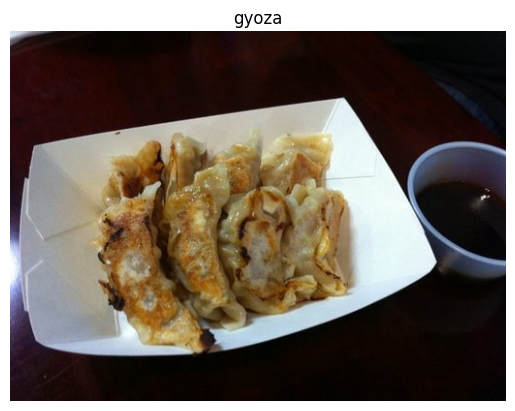

In [11]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Now let's preprocess it and get it ready for use with a neural network.

## Creating preprocessing functions for the dataset

our data looks currently like:

1) In uint8 data type
2) Comprised of all differnet sized tensors (different sized images)
3) Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

1) In float32 data type
2) Have all of the same size tensors (batches require all tensors have the 3) same shape, e.g. (224, 224, 3))
4) Scaled (values between 0 & 1), also called normalized

In [12]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Lets Look at our data before and after preprocessing

In [13]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[207 220 237]
  [207 220 237]
  [207 220 236]
  ...
  [ 10  11  13]
  [ 11  12  14]
  [ 12  13  15]]

 [[208 219 237]
  [207 220 236]
  [208 220 236]
  ...
  [  9  10  12]
  [ 10  11  13]
  [ 11  12  14]]]...,
Shape: (382, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[207.12596  219.87404  236.77328 ]
  [206.75159  219.39891  235.39891 ]
  [206.33514  216.86098  232.36958 ]
  ...
  [ 10.433058  11.433058  13.433058]
  [  9.974804  10.974804  12.974804]
  [ 11.004499  12.004499  14.004499]]

 [[214.51498  225.25287  240.26627 ]
  [214.24043  223.17825  238.07462 ]
  [213.40561  221.28954  234.25638 ]
  ...
  [ 12.571472  13.571472  15.571472]
  [ 11.928558  12.928558  14.928558]
  [ 11.941964  12.941964  14.941964]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Now they are on the desired shape and datatype

Text(0.5, 1.0, 'gyoza')

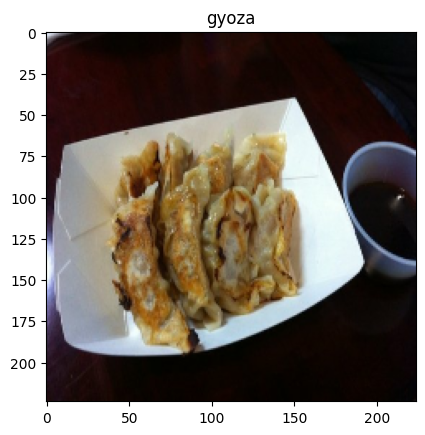

In [14]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])

## Handling Batches and Preparing Datasets
computing on batches is memory efficient.
 we're going to be using:

1) map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
2) shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
3) batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
4) prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
5) (Maybe??) cache() - caches (saves them for later) elements in a target dataset, saving loading time

We're going to through things in the following order:

Original dataset -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset

In [15]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# Lets check them out
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating a Callback
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [17]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 


## Setting up mixed precision training

In [20]:
# # Turn on mixed precision training
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [19]:
# mixed_precision.global_policy()

In [25]:
from tensorflow.keras import layers

## Build feature extraction model

In [22]:


# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"]) 

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Cheking if the model is using mized precision

In [24]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

1) layer.name (str) : a layer's human-readable name, can be defined by the name parameter on construction
2) layer.trainable (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
3) layer.dtype : the data type a layer stores its variables in
4) layer.dtype_policy : the data type a layer computes in

In [25]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


## Fitting the feature exraction model


In [26]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230811-141944
Epoch 1/3
2368/2368 [==============================] - 149s 59ms/step - loss: 1.7185 - accuracy: 0.5833 - val_loss: 1.1286 - val_accuracy: 0.6925
Epoch 2/3
2368/2368 [==============================] - 141s 59ms/step - loss: 1.2003 - accuracy: 0.6890 - val_loss: 1.0327 - val_accuracy: 0.7164
Epoch 3/3
2368/2368 [==============================] - 141s 59ms/step - loss: 1.0532 - accuracy: 0.7235 - val_loss: 0.9893 - val_accuracy: 0.7278


In [27]:
# Evaluating model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 43s 53ms/step - loss: 0.9951 - accuracy: 0.7293


[0.9950703978538513, 0.7293069362640381]

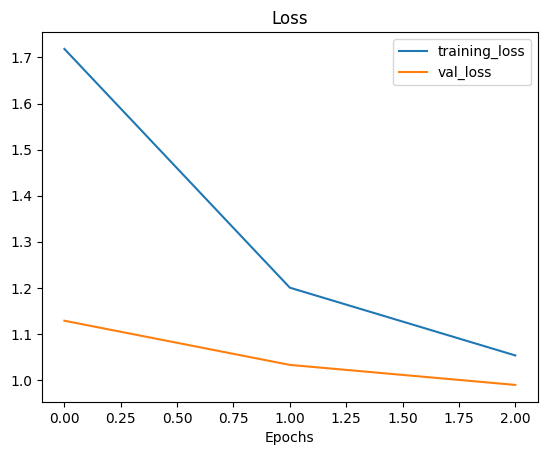

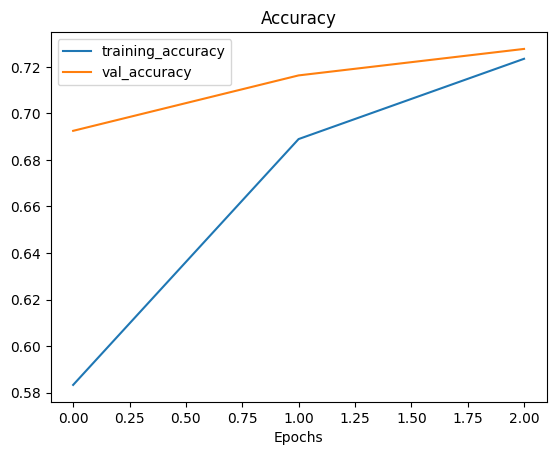

In [28]:
plot_loss_curves(history_101_food_classes_feature_extract)

### Creating another model for further experimentation

Creating a function to return a model so we dont have to write it repetively,

In [23]:
def create_model():
    input_shape = (224,224,3)
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
    base_model.trainable = False
    
    #creating a functional model
    inputs = layers.Input(shape = input_shape, name = "Input_Layer")
    x = base_model(inputs,training = False)
    x = layers.GlobalAveragePooling2D(name = "Pooling_Layer")(x)
    x = layers.Dense(len(class_names))(x)
    outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
    model = tf.keras.Model(inputs, outputs)
    return model


Creating model_2 and compiling

In [30]:
model_2 = create_model()
model_2.compile(loss = "sparse_categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])


In [31]:
# Loading the saved weights of the 1st model.
model_2.load_weights(checkpoint_path)

In [32]:
# Checking by evaluating the model_2 if its same as model 1
model_2.evaluate(test_data)

790/790 [==============================] - 43s 52ms/step - loss: 0.9951 - accuracy: 0.7293


[0.9950695633888245, 0.7293069362640381]

### Changing the trainable parameters of the Base model (EfficientNetB0)

In [33]:
model_2.layers

In [34]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001A585194F40> True
<keras.engine.functional.Functional object at 0x000001A3F2B2A2E0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001A58776B280> True
<keras.layers.core.dense.Dense object at 0x000001A58776BD60> True
<keras.layers.core.activation.Activation object at 0x000001A587B65670> True


In [35]:
# Checking the efficientnetb0 architecture layers to see if they are trainable
for i, layer in enumerate(model_2.layers[1].layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [36]:
# Unfreezing the last 20 layers
model_2.layers[1].trainable = True

# Freeze all layers except for the
for layer in model_2.layers[1].layers[:-16]:
  layer.trainable = False

In [37]:
# Checking to see if they are trainable
for i, layer in enumerate(model_2.layers[1].layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

### Setting up callbacks

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_2_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [19]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [40]:
# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

### Fitting the model

First fitting the model for 3 epochs without EarlyStopping and ReduceLROnPlatue Callbacks, while unfreezingtop 16 layers in EfficientNetB0 model.

In [41]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = model_2.fit(train_data,
                                                        epochs=3, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230811-170818
Epoch 1/3
2368/2368 [==============================] - 159s 65ms/step - loss: 0.8612 - accuracy: 0.7718 - val_loss: 0.8847 - val_accuracy: 0.7566
Epoch 2/3
2368/2368 [==============================] - 155s 65ms/step - loss: 0.6789 - accuracy: 0.8183 - val_loss: 0.8694 - val_accuracy: 0.7582
Epoch 3/3
2368/2368 [==============================] - 155s 65ms/step - loss: 0.5376 - accuracy: 0.8561 - val_loss: 0.8860 - val_accuracy: 0.7590


In [42]:
model_2.evaluate(test_data)

790/790 [==============================] - 44s 55ms/step - loss: 0.8935 - accuracy: 0.7601


[0.8935166597366333, 0.7600792050361633]

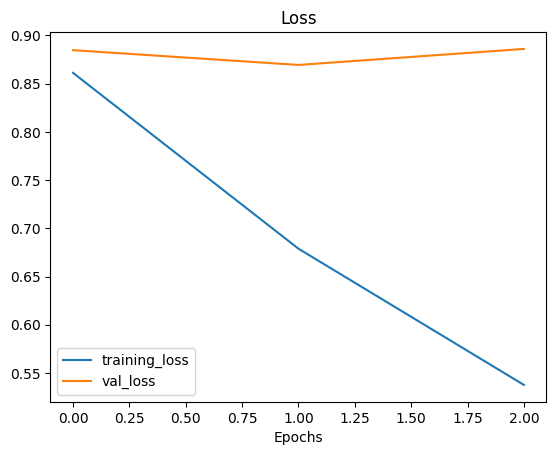

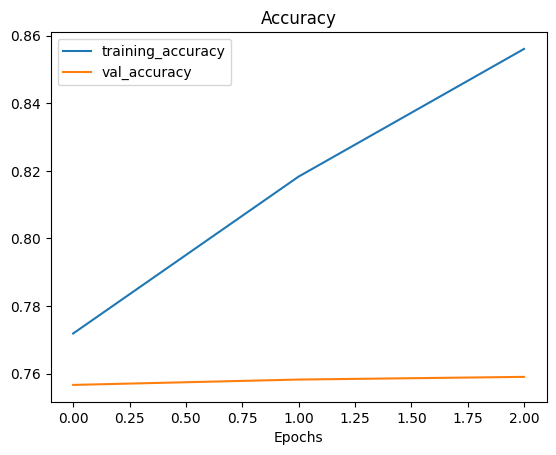

In [43]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)

# Experiment - 2

### This will be a copy of model_2 and in this one we will unfreeze all the Layers in the EfficientNetB0 Architecture for fine tuning.

In [30]:
model_3 = create_model()
model_3.compile(loss = "sparse_categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [31]:
# Loading the saved weights of model_2
model_3.load_weights("model_checkpoints/cp.ckpt")

In [32]:
model_3.evaluate(test_data)

790/790 [==============================] - 44s 53ms/step - loss: 0.8935 - accuracy: 0.7601


[0.8935168385505676, 0.7600792050361633]

### Changing the trainable parameters of the efficientNetB0 architecture 

In [33]:
# Checking the efficientnetb0 architecture layers to see if they are trainable
for i, layer in enumerate(model_3.layers[1].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [34]:
# Unfreezing the last 20 layers
model_3.layers[1].trainable = True
for i, layer in enumerate(model_3.layers[1].layers):
    print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling_2 True
2 normalization_2 True
3 tf.math.truediv_2 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 b

### Setting up callback

In [36]:
# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "exp_2_checkpoints/exp2.ckpt"
model_3_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

### Compiling

In [37]:
# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [38]:
# Now Fine-Tuning all the layers
history_101_food_classes_all_data_fine_tune = model_3.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs ( it will stop in between)
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), 
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_3_checkpoint, 
                                                                   early_stopping, 
                                                                   reduce_lr]) 

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230812-145838
Epoch 1/100
  18/2368 [..............................] - ETA: 46:07 - loss: 0.5622 - accuracy: 0.8455

KeyboardInterrupt: 